In [57]:
%matplotlib inline
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
import pickle
import torchmetrics
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn.functional as F

## Layer Initialization and Transfer Learning

### Freeze layers of a model

In [8]:
# Create a 4-layer linear network that takes 8 input features from input_tensor and produces 10 regression output.
input_tensor = torch.Tensor([[3, 4, 6, 7, 10, 12, 2, 3]])

# Implement a neural network with exactly four linear layers
model = nn.Sequential(
  nn.Linear(8, 16),
  nn.Linear(16, 32),
  nn.Linear(32, 10)
)

output = model(input_tensor)
print(output)

# Task is to train only the last linear layer of this model and freeze the first two linear layers.

#Use an if statement to determine if the parameter should be frozen or not based on its name.

for name, param in model.named_parameters():    
  
    # Check if the parameters belong to the first layer
    if name == '0.weight':
      
        # Freeze the parameters
        param.requires_grad = False
  
    # Check if the parameters belong to the second layer
    if name == '1.weight':
      
        # Freeze the parameters
        param.requires_grad = False

<class 'torch.Tensor'>
tensor([[ 2.3212,  0.6773, -0.7743, -0.3719,  0.8583,  0.9111, -0.3750,  0.4561,
         -0.8079, -0.6421]], grad_fn=<AddmmBackward0>)


### Layer Initialization

In [27]:
random_numbers = np.random.uniform(low=-2, high=12, size=16).astype(np.float32)

input_tensor = torch.from_numpy(random_numbers)

layer0 = nn.Linear(16, 32)
layer1 = nn.Linear(32, 64)

nn.init.uniform_(layer0.weight)
nn.init.uniform_(layer1.weight)

# # Implement a neural network with exactly four linear layers
model = nn.Sequential(layer0, layer1)

output = model(input_tensor)


tensor([382.0644, 381.7974, 412.2797, 454.4508, 406.0322, 416.0537, 387.9502,
        415.3087, 395.1567, 402.9168, 403.8720, 389.9672, 397.3943, 419.1433,
        374.3557, 390.0723, 431.1855, 341.9128, 375.0736, 404.5716, 418.6308,
        440.1833, 493.5712, 431.8582, 376.4826, 455.3007, 377.9301, 405.6681,
        402.1248, 419.9512, 377.9842, 460.6865, 409.2059, 419.3811, 386.1362,
        434.0216, 469.3418, 409.9371, 404.0838, 446.6445, 358.8353, 469.8241,
        435.9679, 447.9725, 486.2414, 454.9444, 438.6491, 436.6408, 368.0972,
        404.3836, 470.5710, 393.2542, 491.0186, 405.8979, 309.9807, 412.6425,
        479.3357, 438.3076, 384.8696, 481.4535, 401.9032, 397.4716, 397.5204,
        465.7252], grad_fn=<ViewBackward0>)


## Evaluating Model Performance

### Writing the evaluation loop

In [32]:
# Write an evaluation loop to compute validation loss. The evaluation loop follows a similar structure to the training loop but without gradient calculations or weight updates.
dataset = TensorDataset()
validationloader = DataLoader(dataset=dataset, batch_size=8, shuffle=True)

layer0 = nn.Linear(16, 32)
layer1 = nn.Flatten(start_dim=1,end_dim=1)
layer2 = nn.Linear(in_features=3072,out_features=3)

model = nn.Sequential(layer0, layer1, layer2)

# Create the cross entropy loss function and store it as criterion
criterion = CrossEntropyLoss()

# Set the model to evaluation mode
model.eval()
validation_loss = 0.0

with torch.no_grad():
  
  for features, labels in validationloader:
    
      outputs = model(features)
      loss = criterion(outputs, labels)
      
      # Sum the current loss to the validation_loss variable
      validation_loss += loss.item()

# Calculate the mean loss value
validation_loss_epoch = validation_loss / len(validationloader)
print(validation_loss_epoch)

# Set the model back to training mode
model.train()

IndexError: tuple index out of range

### Calculating accuracy using torchmetrics

In [56]:
#  This function highlight misclassified samples, helping to analyze model errors.
def plot_errors(model, dataloader): 
    # find mismatches
    mismatches = []
    for data in dataloader:
        if len(mismatches) > 8:
            break
        features, labels = data
        outputs = model(features)
        gt = labels.argmax(-1)
        pred = outputs.argmax(-1)
        for f, g, p in zip(features, gt, pred):
            if g != p:
                mismatches.append((f, g, p))
    
    
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 4),  # creates 2x2 grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    mapping = {0: 'No mask', 1: 'Mask', 2: 'Incorrect'}
    for idx, ax in enumerate(grid):
        ax.imshow(mismatches[idx][0].permute(1, 2, 0))
        ax.set_title(f'GT: {mapping[mismatches[idx][1].item()]} \n PRED: {mapping[mismatches[idx][2].item()]}')
        ax.axis('off')
    plt.show()

In [59]:
# unpickle data

# load the data from a file
with open('../../data/masks_dataset.pickle', 'rb') as f:
    data = pickle.load(f)
    
X = data[0]   
y = data[1]

num_classes = 3

# Create a dataset
dataset = TensorDataset(torch.tensor(X), torch.tensor(y))

# Create a DataLoader using dataset, setting a batch size of two and enabling shuffling.
dataloader = DataLoader(dataset=dataset, batch_size=8,shuffle=True)

# Create the one-hot encoded vector using PyTorch
labels = F.one_hot(torch.tensor(y), num_classes=num_classes)

layer0 = nn.Linear(16, 32)
layer1 = nn.Flatten(start_dim=1,end_dim=1)
layer2 = nn.Linear(in_features=3072,out_features=3)

model = nn.Sequential(layer0, layer1, layer2)

# Create accuracy metric
metric = torchmetrics.Accuracy(task="multiclass", num_classes=3)
for features, labels in dataloader:
    outputs = model(features)
    
    # Calculate accuracy over the batch
    metric.update(outputs, labels.argmax(dim=-1))

# Calculate accuracy over the whole epoch
accuracy = metric.compute()
print(f"Accuracy on all data: {accuracy}")

# Reset metric for the next epoch
metric.reset()
plot_errors(model, dataloader)    
    

tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        ...,
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]])


## Fighting Overfitting

### Experimenting with dropout

In [64]:
features = torch.Tensor([ 1.6057,  1.9775, -0.0190, -0.7357, -0.0915, -0.4068,  1.7507, -0.1622])

# Add a dropout layer to the model with a 50% probability of zeroing out elements.
# Model with Dropout
model = nn.Sequential(
    nn.Linear(8, 6),
    nn.Linear(6, 4),
    nn.Dropout(p=0.5))

# Set the model to training mode and generate predictions using features, storing the output as output_train
model.train()
output_train = model(features)

#Set the model to evaluation mode to disable dropout.
model.eval()
# Generate predictions using features, storing the output as output_eval.
output_eval = model(features)

# Print results
print("Output in train mode:", output_train)
print("Output in eval mode:", output_eval)

Output in train mode: tensor([-0.0000,  0.0000, -0.0291, -2.5945], grad_fn=<MulBackward0>)
Output in eval mode: tensor([-0.6662,  0.8172, -0.0146, -1.2973], grad_fn=<ViewBackward0>)


## Improving Model Performance

In [65]:
def plot_hyperparameter_search(values):
    lrs, momentums = zip(*values)

    plt.figure(figsize=(8, 6))
    plt.scatter(lrs, momentums)
    plt.xscale("log")  # Use log scale for learning rate
    plt.xlabel("Learning Rate")
    plt.ylabel("Momentum")
    # plt.title("Randomly Sampled Learning Rates and Momentum")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Set specific tick marks on the x-axis
    plt.xticks([10**-2, 10**-3, 10**-4], 
               [r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$'])

    plt.show()

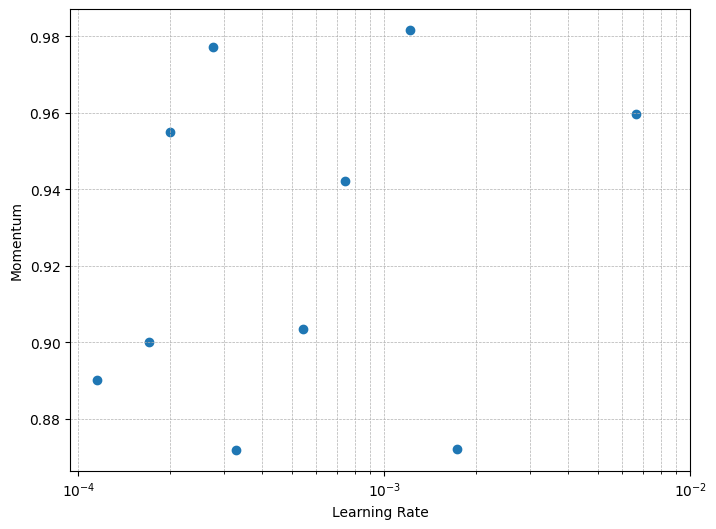

In [66]:
# Randomly sample a learning rate factor between 2 and 4 so that the learning rate (lr) is bounded between 10**-2  and 10**-4.
values = []
for idx in range(10):
    # Randomly sample a learning rate factor between 2 and 4
    factor = np.random.uniform(2, 4)
    lr = 10 ** -factor
    
    # Randomly select a momentum between 0.85 and 0.99
    momentum = np.random.uniform(0.85, 0.99)
    
    values.append((lr, momentum))
       
plot_hyperparameter_search(values)